# **Instrument to Instrument (ITI) translation: SOHO/EIT-to-SDO/AIA**

## Read The Docs
For more information about the tool and background of the individual case studies see:

[iti-documentation.rtfd.io](https://iti-documentation.readthedocs.io/en/latest/)

STEREO provides a better resolution than SOHO. For this application we consider the full 4096x4096 pixel resolution of SDO as our reference. 

## Installation

In [1]:
!pip install git+https://github.com/spaceml-org/InstrumentToInstrument.git@development
!pip install lightning
!pip install sunpy_soar
!pip install sunpy

  Cloning https://github.com/spaceml-org/InstrumentToInstrument.git (to revision development) to /private/var/folders/tj/7h3lqn950sv5k36g1yyl4vkr0000gn/T/pip-req-build-vbgk8wm9
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/InstrumentToInstrument.git /private/var/folders/tj/7h3lqn950sv5k36g1yyl4vkr0000gn/T/pip-req-build-vbgk8wm9
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Resolved https://github.com/spaceml-org/InstrumentToInstrument.git to commit b083c705d463997caebf2df663d8774cbe569eda
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1

## Imports

In [2]:
from iti.translate import *
import glob
from matplotlib.colors import Normalize
from iti.evaluation.util import download_gcp_bucket
from datetime import datetime
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings('ignore')

base_path = os.getcwd()

## Download data


SOHO and EIT files requires a pre-processing that is only available in SSWIDL. We provide a sample observation from each Instrument. If you want to make use of custom files, use the prep routines and upload your files.

We provide a publicly available dataset which allows the users to play around with a subset of the data available without downloading the entire database.

This dataset contains ``.fits`` files from **PROBA2/SWAP**, **SDO/AIA**, **Solar Orbiter/EUI (FSI and HRI)**, **SOHO/EIT** and **STEREO/EUVI**.

In addition 3 trained models are stored with:
1. PROBA2/SWAP to SDO/AIA
2. Solar Orbiter/EUI FSI to SDO/AIA and
3. SDO/AIA to Solar Orbiter/EUI HRI

to perform the translation.  

In [3]:
download_gcp_bucket('iti-dataset', base_path+'/iti-testset')

Failed to download configs/ due to exception: [Errno 21] Is a directory: '/Users/christophschirninger/PycharmProjects/ITI/examples/iti-testset/configs/'
Downloaded configs/proba2_to_sdo_colab.yaml to /Users/christophschirninger/PycharmProjects/ITI/examples/iti-testsetconfigs/proba2_to_sdo_colab.yaml.
Failed to download models/ due to exception: [Errno 21] Is a directory: '/Users/christophschirninger/PycharmProjects/ITI/examples/iti-testset/models/'
Downloaded models/aia_to_hri_v0_1.pt to /Users/christophschirninger/PycharmProjects/ITI/examples/iti-testsetmodels/aia_to_hri_v0_1.pt.
Downloaded models/fsi_to_aia_v0_3.pt to /Users/christophschirninger/PycharmProjects/ITI/examples/iti-testsetmodels/fsi_to_aia_v0_3.pt.
Downloaded models/swap_to_aia_v0_4.pt to /Users/christophschirninger/PycharmProjects/ITI/examples/iti-testsetmodels/swap_to_aia_v0_4.pt.
Failed to download proba2/174/ due to exception: [Errno 21] Is a directory: '/Users/christophschirninger/PycharmProjects/ITI/examples/iti-te

We load the previously downloaded SOHO files. The translator requires a list of the four aligned FITS files for each translation.

In [7]:
stereo_files = sorted(glob.glob(base_path+'/iti-testset/stereo/**/*.fits', recursive=True))
stereo_maps = [Map(f).rotate() for f in stereo_files]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


The translator classes are the core element of the ITI translation. They follow the notation: ``InstrumentAToInstrumentB``. The translator will return a list of lists of maps with the translated observations.


In [8]:
translator = STEREOToSDO()
iti_stereo_maps = list(translator.translate([[f] for f in stereo_files]))[0]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


We can now compare the full-disk SunPy maps against each other.

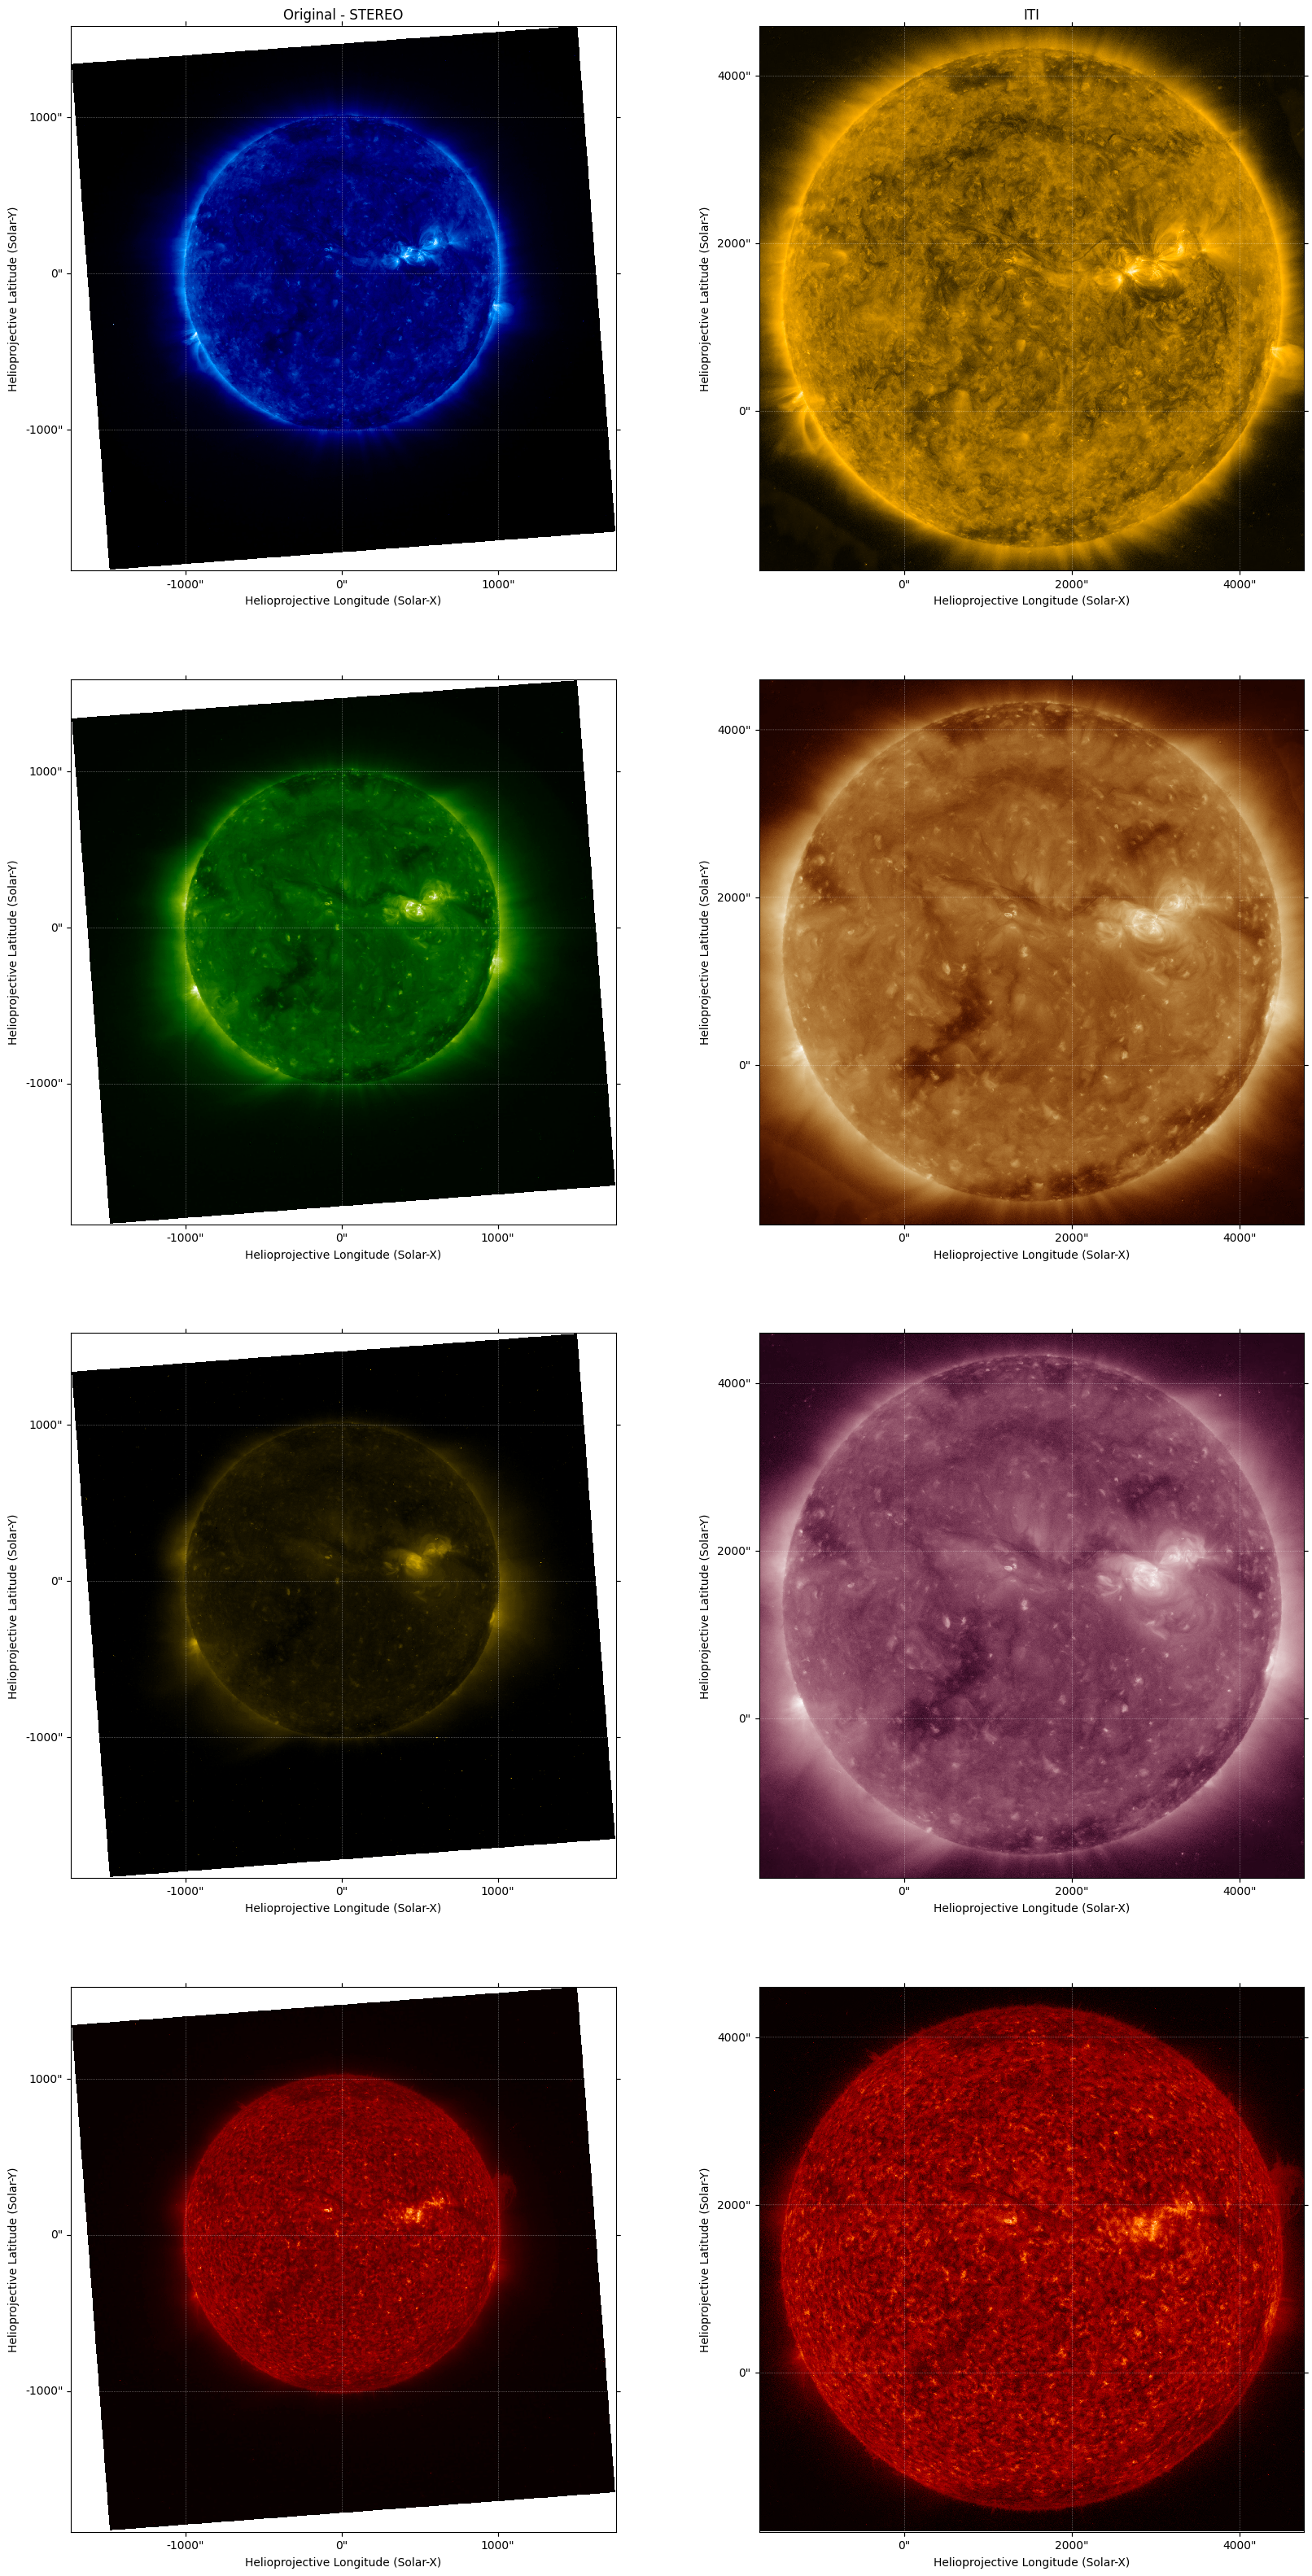

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(20, 40), subplot_kw={'projection': stereo_maps[0]})
for i, (stereo_map, iti_map) in enumerate(zip(stereo_maps, iti_stereo_maps)):
    stereo_map.plot(axes=axs[i,0])
    iti_map.plot(axes=axs[i,1])
[ax.set_title('') for ax in np.ravel(axs)]
axs[0,0].set_title('Original - STEREO')
axs[0,1].set_title('ITI')
plt.show()

The full-disk images show that the value scaling is adjusted by ITI to correspond to SDO observations. Next, we investigate the enhancement at smaller scales.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Miss

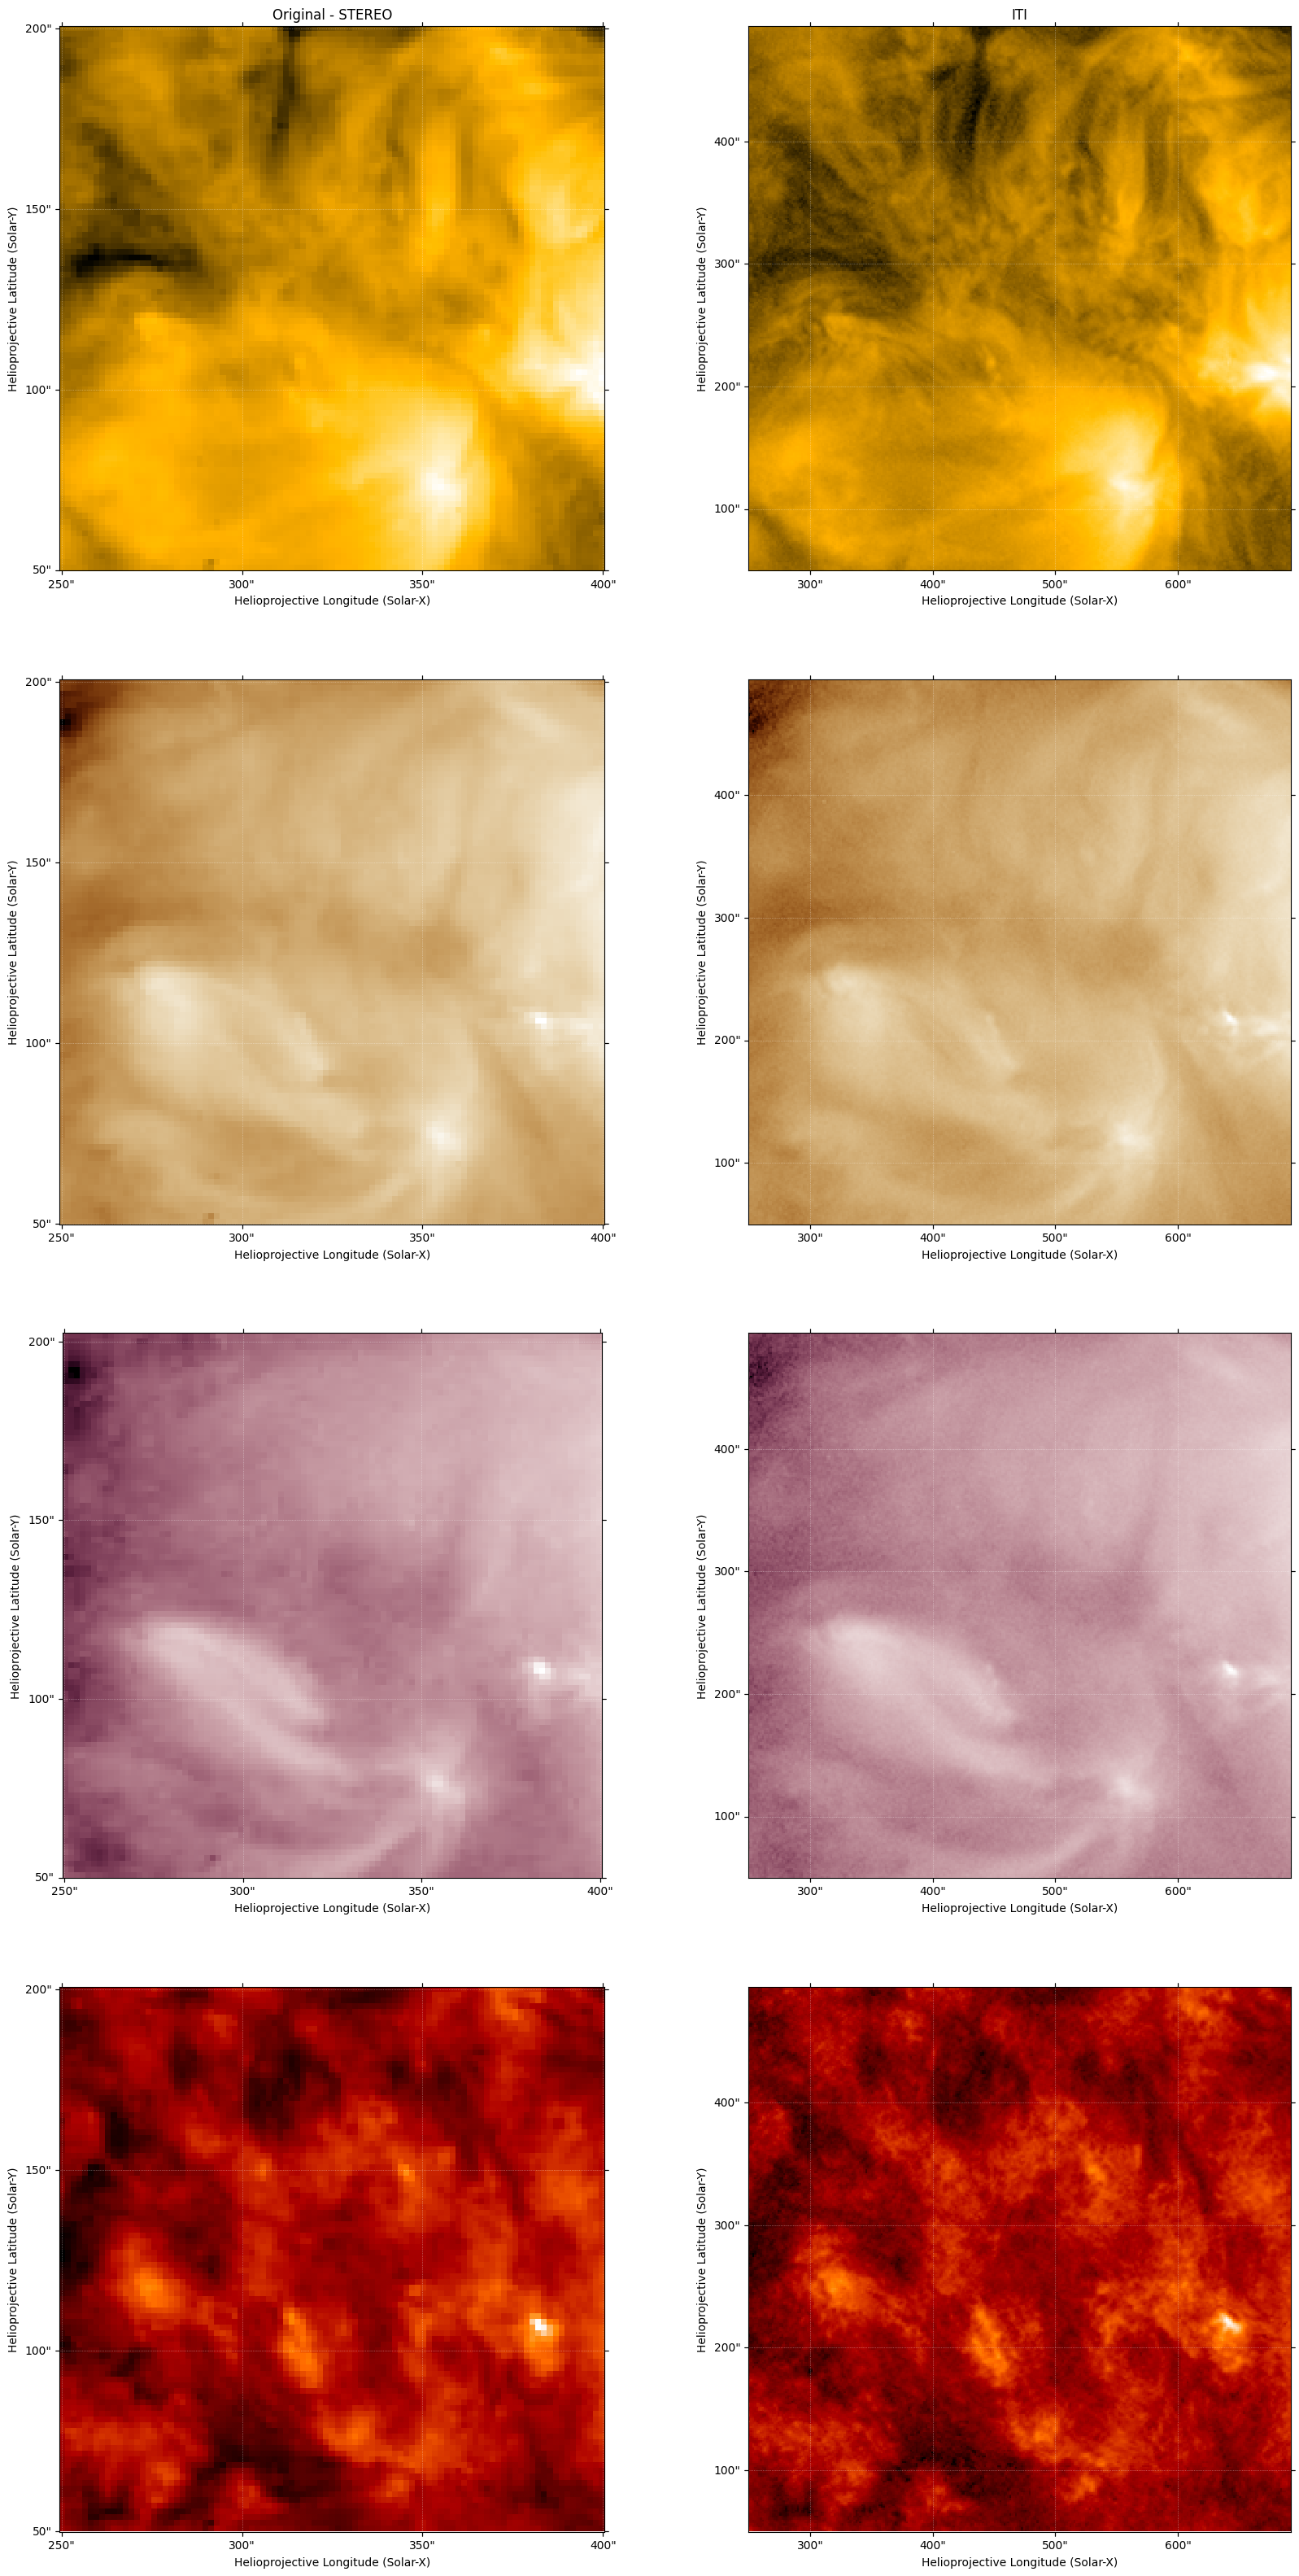

In [10]:
bl = SkyCoord(250 * u.arcsec, 50 * u.arcsec, frame=iti_stereo_maps[0].coordinate_frame)
tr = SkyCoord(400 * u.arcsec, 200 * u.arcsec, frame=iti_stereo_maps[0].coordinate_frame)

fig, axs = plt.subplots(4, 2, figsize=(20, 40), subplot_kw={'projection': stereo_maps[0].submap(bl, top_right=tr)})
for i, (stereo_map, iti_map) in enumerate(zip(stereo_maps, iti_stereo_maps)):
    stereo_map.submap(bl, top_right=tr).plot(axes=axs[i,0], **iti_map.plot_settings)
    iti_map.submap(bl, top_right=tr).plot(axes=axs[i,1], **iti_map.plot_settings)
[ax.set_title('') for ax in np.ravel(axs)]
axs[0,0].set_title('Original - STEREO')
axs[0,1].set_title('ITI')
plt.show()